**Part 1: GAN**

Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
import torch.nn as nn
import matplotlib.pyplot as plt

100%|██████████| 26421880/26421880 [00:04<00:00, 5447602.61it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 369703.61it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6269178.39it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16065682.29it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])
Label: 9
first batch
torch.Size([100, 1, 28, 28])
tensor([0, 8, 7, 3, 5, 4, 9, 9, 5, 3, 6, 9, 1, 5, 3, 4, 2, 4, 5, 4, 3, 3, 9, 9,
        3, 6, 5, 7, 6, 0, 8, 3, 6, 4, 4, 5, 1, 0, 4, 8, 3, 1, 5, 3, 1, 8, 6, 6,
        0, 7, 4, 1, 2, 0, 8, 9, 7, 0, 7, 0, 2, 6, 2, 7, 8, 7, 6, 2, 7, 0, 0, 7,
        7, 9, 8, 1, 7, 1, 8, 6, 2, 8, 8, 9, 9, 8, 6, 9, 0, 5, 3, 4, 7, 4, 4, 3,
        0, 3, 7, 7])


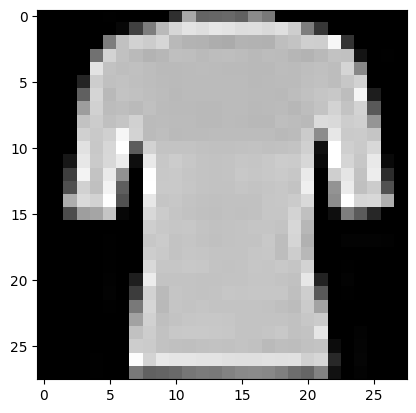

In [ ]:
# Load Fashion MNIST dataset
fashion_mnist = FashionMNIST(root='data',
                             train=True,
                             download=True,
                             transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

# Denormalize function for visualization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Visualize an image from the dataset
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

# DataLoader
from torch.utils.data import DataLoader
batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

# Test DataLoader
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
device

device(type='cpu')

Step2. Train the GAN model to produce images in this new domain.




In [ ]:
# Define the Generator model
latent_size = 64
image_size = 784  # 28x28 pixels
hidden_size = 256

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

# Define the Discriminator model
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# Move models to GPU if available
G.to(device)
D.to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# Reset gradients
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Function to train the Discriminator
def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Train on real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Train on fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses and update the Discriminator
    d_loss = d_loss_real + d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_score, fake_score

# Function to train the Generator
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)  # The generator wants the discriminator to output ones
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images



Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

Epoch 50/200, D Loss: 0.4220, G Loss: 2.2176
Epoch 100/200, D Loss: 0.8454, G Loss: 1.9839
Epoch 150/200, D Loss: 1.3633, G Loss: 0.9664
Epoch 200/200, D Loss: 1.1622, G Loss: 1.1701


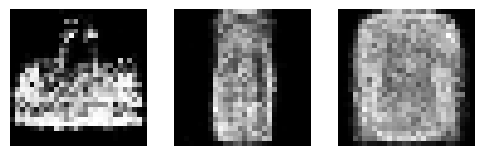

In [ ]:
import torch
import torchvision.utils as vutils
import os
import matplotlib.pyplot as plt

# Directory to save generated images
sample_dir = 'samples'
os.makedirs(sample_dir, exist_ok=True)

# Function to save generated images
def save_fake_images(epoch, fake_images):
    # Reshape the fake images for saving
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

    # Save the images using torchvision's utility function
    fake_fname = f'fake_images_epoch_{epoch:03d}.png'
    vutils.save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname))

# Function to generate and display images after training
def generate_and_display_images(generator, num_images=3, latent_size=64, device='cpu'):
    # Generate latent vectors
    z = torch.randn(num_images, latent_size).to(device)

    # Generate images using the generator
    with torch.no_grad():
        generated_images = generator(z).cpu()

    # Reshape images and denormalize them
    generated_images = generated_images.reshape(num_images, 1, 28, 28)
    generated_images = denorm(generated_images)

    # Plot the images
    plt.figure(figsize=(num_images * 2, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i][0], cmap='gray')
        plt.axis('off')
    plt.show()

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    for images, _ in data_loader:
        images = images.view(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        # Train the generator
        g_loss, fake_images = train_generator()

    # Save and display generated images every 50 epochs
    if (epoch + 1) % 50 == 0:
        save_fake_images(epoch+1, fake_images)  # Save images
        print(f'Epoch {epoch+1}/{num_epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

# After training, display 3 generated images
generate_and_display_images(G, num_images=3, latent_size=latent_size, device=device)


1: The quality of the generated images was very poor in the early stage of training as the model is still in the learning stage and tries to learn the distribution of data.

2: Took a lot of time to train GAN to generate recognizable images.

3: Faced out-of-memory issues while training GAN on GPU depecding on batch size and network complexity. Switched to CPU which made the training very slow.


Step4. Save the model weights in the folder to be used later.



In [ ]:
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')

Step5. Load the model using the saved weights.



In [ ]:
G.load_state_dict(torch.load('generator.pth'))
D.load_state_dict(torch.load('discriminator.pth'))

# Move models to the appropriate device
G.to(device)
D.to(device)

print("Model weights loaded successfully!")

Model weights loaded successfully!


<ipython-input-7-d2763a03c3b1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('generator.pth'))
<ipython-input-7-d2763a03c3b1>:2: FutureWarnin

Step 6: Re-train the GAN model to see if you can improve.



Retraining Epoch: 1/150, D Loss: 0.9445, G Loss: 1.3984
Retraining Epoch: 2/150, D Loss: 1.0819, G Loss: 1.1177
Retraining Epoch: 3/150, D Loss: 1.4310, G Loss: 1.0295
Retraining Epoch: 4/150, D Loss: 0.7650, G Loss: 1.5426
Retraining Epoch: 5/150, D Loss: 1.2594, G Loss: 1.2198
Retraining Epoch: 6/150, D Loss: 1.3662, G Loss: 0.9335
Retraining Epoch: 7/150, D Loss: 0.7911, G Loss: 1.6803
Retraining Epoch: 8/150, D Loss: 0.9424, G Loss: 1.4055
Retraining Epoch: 9/150, D Loss: 1.1322, G Loss: 1.1545
Retraining Epoch: 10/150, D Loss: 1.0405, G Loss: 1.2109
Retraining Epoch: 11/150, D Loss: 1.1797, G Loss: 0.9738
Retraining Epoch: 12/150, D Loss: 0.9258, G Loss: 1.4557
Retraining Epoch: 13/150, D Loss: 0.8246, G Loss: 1.4802
Retraining Epoch: 14/150, D Loss: 1.3219, G Loss: 1.1087
Retraining Epoch: 15/150, D Loss: 1.2828, G Loss: 1.3523
Retraining Epoch: 16/150, D Loss: 0.8299, G Loss: 1.3389
Retraining Epoch: 17/150, D Loss: 1.1716, G Loss: 1.2915
Retraining Epoch: 18/150, D Loss: 1.2144

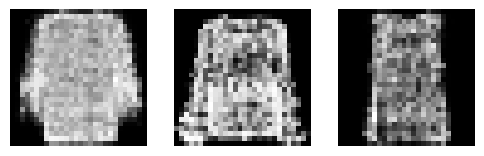

In [ ]:
# Re-train the GAN model for additional epochs
additional_epochs = 150

for epoch in range(additional_epochs):
    print(f'Retraining Epoch: {epoch+1}/{additional_epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}', flush=True)

    for images, _ in data_loader:
        images = images.view(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        # Train the generator
        g_loss, fake_images = train_generator()

    # Save and display generated images every 50 epochs during re-training
    if (epoch + 1) % 50 == 0:
        save_fake_images(epoch+1, fake_images)  # Save new images
        print(f'Epoch {epoch+1}/{additional_epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}', flush=True)

# After re-training, you can display new generated images
generate_and_display_images(G, num_images=3, latent_size=latent_size, device=device)


Step 7: Save the model weights without using checkpoints.



In [ ]:
torch.save(G.state_dict(), 'generator_final.pth')
torch.save(D.state_dict(), 'discriminator_final.pth')

print("Re-trained model weights saved successfully!")

Re-trained model weights saved successfully!


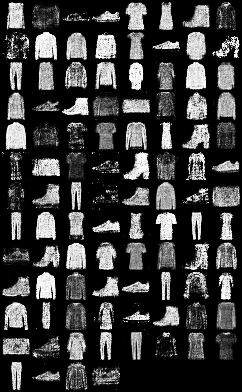

In [ ]:
from IPython.display import Image

# Display the saved image
Image('./samples/fake_images_epoch_050.png')

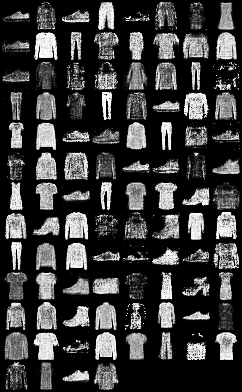

In [ ]:
Image('./samples/fake_images_epoch_100.png')

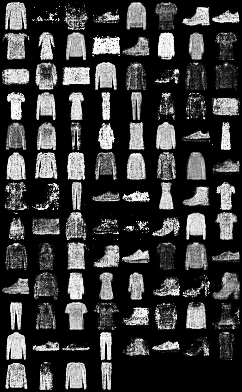

In [ ]:
Image('./samples/fake_images_epoch_150.png')

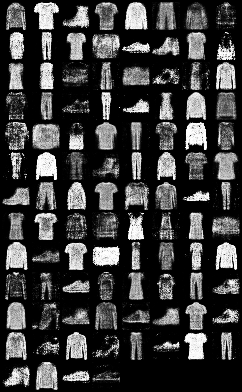

In [ ]:
Image('./samples/fake_images_epoch_200.png')

Step 8: Load the model weights without using checkpoints.



In [ ]:
# Load the final model weights (without checkpoints)
G.load_state_dict(torch.load('generator_final.pth'))
D.load_state_dict(torch.load('discriminator_final.pth'))

# Move models to the appropriate device
G.to(device)
D.to(device)

print("Final model weights loaded successfully!")

Final model weights loaded successfully!


<ipython-input-17-a3ab82e5332b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('generator_final.pth'))
<ipython-input-17-a3ab82e5332b>:3: Futu

**Part 2 LSGAN:**

Step 1: Load the Fashion MNIST dataset


In [5]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

# Load Fashion MNIST Dataset
fashion_mnist = FashionMNIST(root='data',
                             train=True,
                             download=True,
                             transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

# Data loader for batching
batch_size = 100
data_loader = torch.utils.data.DataLoader(fashion_mnist, batch_size=batch_size, shuffle=True)

# Print the shape of a single image and label
img, label = fashion_mnist[0]
print('Label:', label)
print('Image shape:', img.shape)


Label: 9
Image shape: torch.Size([1, 28, 28])


Step 2: Modify GAN Loss to Least Squares Loss (LSGAN)


In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
image_size = 784  # 28x28 images
hidden_size = 256
latent_size = 64

# Discriminator network (unchanged)
D = torch.nn.Sequential(
    torch.nn.Linear(image_size, hidden_size),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(hidden_size, 1)
)
D.to(device)

# Generator network (unchanged)
G = torch.nn.Sequential(
    torch.nn.Linear(latent_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, image_size),
    torch.nn.Tanh()
)
G.to(device)

# LSGAN Loss function
criterion = torch.nn.MSELoss()

# Optimizers
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# Helper functions
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Training loop for LSGAN
def train_lsgan(num_epochs):
    d_losses, g_losses = [], []

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):
            # Reshape images to vectors and send to device
            images = images.reshape(batch_size, -1).to(device)

            # Train discriminator
            real_labels = torch.ones(batch_size, 1).to(device)  # Real = 1
            fake_labels = torch.zeros(batch_size, 1).to(device)  # Fake = 0

            # Real images loss
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels)

            # Fake images loss
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)

            # Total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

            reset_grad()
            d_loss.backward()
            d_optimizer.step()

            # Train generator
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            g_loss = criterion(D(fake_images), real_labels)  # Minimize (D(G(z)) - 1)^2

            reset_grad()
            g_loss.backward()
            g_optimizer.step()

            # Log losses
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss:.4f}, g_loss: {g_loss:.4f}')

# Train the LSGAN model
train_lsgan(num_epochs=100)


Epoch [1/100], d_loss: 0.0037, g_loss: 1.0865
Epoch [2/100], d_loss: 0.0070, g_loss: 1.1598
Epoch [3/100], d_loss: 0.0080, g_loss: 1.1351
Epoch [4/100], d_loss: 0.0057, g_loss: 1.0888
Epoch [5/100], d_loss: 0.0091, g_loss: 1.0872
Epoch [6/100], d_loss: 0.0162, g_loss: 1.2037
Epoch [7/100], d_loss: 0.0132, g_loss: 1.0791
Epoch [8/100], d_loss: 0.0160, g_loss: 1.2563
Epoch [9/100], d_loss: 0.0262, g_loss: 0.9577
Epoch [10/100], d_loss: 0.0258, g_loss: 0.9999
Epoch [11/100], d_loss: 0.0470, g_loss: 0.9687
Epoch [12/100], d_loss: 0.0439, g_loss: 1.0214
Epoch [13/100], d_loss: 0.0256, g_loss: 0.9415
Epoch [14/100], d_loss: 0.0404, g_loss: 0.9985
Epoch [15/100], d_loss: 0.0496, g_loss: 0.9954
Epoch [16/100], d_loss: 0.0417, g_loss: 0.8165
Epoch [17/100], d_loss: 0.0657, g_loss: 1.1099
Epoch [18/100], d_loss: 0.0484, g_loss: 0.9316
Epoch [19/100], d_loss: 0.0374, g_loss: 1.0702
Epoch [20/100], d_loss: 0.0439, g_loss: 0.8240
Epoch [21/100], d_loss: 0.0598, g_loss: 0.9603
Epoch [22/100], d_loss

Step 3: Save and Display at Least 3 Samples Produced


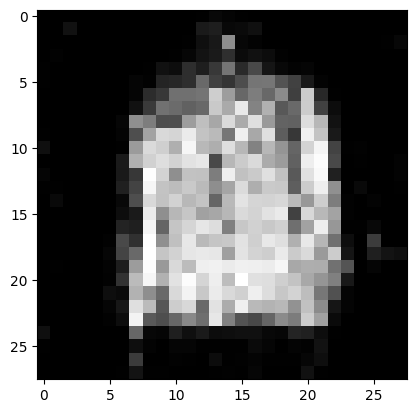

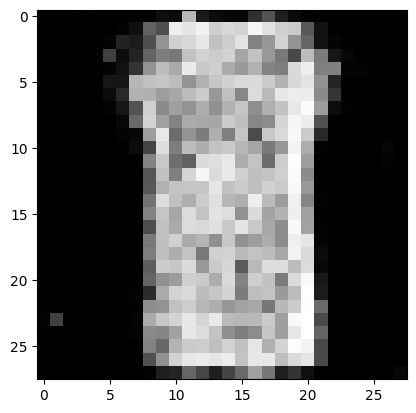

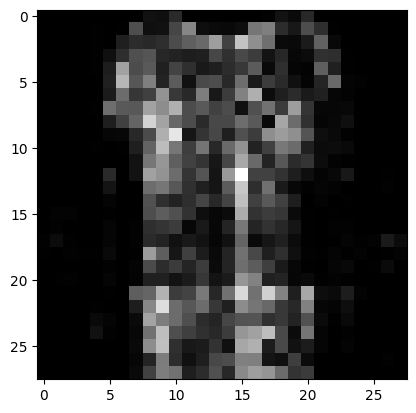

In [7]:
import matplotlib.pyplot as plt

def save_and_display_samples(num_samples=3):
    z = torch.randn(num_samples, latent_size).to(device)
    fake_images = G(z)
    fake_images = denorm(fake_images.view(fake_images.size(0), 28, 28)).cpu().detach()

    for i in range(num_samples):
        plt.imshow(fake_images[i], cmap='gray')
        plt.show()

# Helper function to denormalize the image (convert from [-1, 1] back to [0, 1])
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Save and display 3 samples
save_and_display_samples()


1: GPU failed to train LSGAN. Had to use CPU.

2: Took very long to train the model.

Step 4: Save the Model Weights


In [8]:
# Save the model weights for the generator and discriminator
torch.save(G.state_dict(), 'lsgan_fashion_G.ckpt')
torch.save(D.state_dict(), 'lsgan_fashion_D.ckpt')
print("LSGAN model weights saved.")


LSGAN model weights saved.


Step 5: Load the Model Using Saved Weights


In [9]:
# Load the saved model weights for both generator and discriminator
G.load_state_dict(torch.load('lsgan_fashion_G.ckpt'))
D.load_state_dict(torch.load('lsgan_fashion_D.ckpt'))
G.to(device)
D.to(device)
print("LSGAN model weights loaded.")


LSGAN model weights loaded.


<ipython-input-9-ef4a7d8de9d3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('lsgan_fashion_G.ckpt'))
<ipython-input-9-ef4a7d8de9d3>:3: Futur

Step 6: Re-train the model to Improve


In [10]:

# Re-train the LSGAN model using loaded weights
train_lsgan(num_epochs=100)


Epoch [1/100], d_loss: 0.1187, g_loss: 0.5202
Epoch [2/100], d_loss: 0.1101, g_loss: 0.7724
Epoch [3/100], d_loss: 0.1641, g_loss: 0.6719
Epoch [4/100], d_loss: 0.0987, g_loss: 0.6566
Epoch [5/100], d_loss: 0.1545, g_loss: 0.6226
Epoch [6/100], d_loss: 0.1979, g_loss: 0.5400
Epoch [7/100], d_loss: 0.1584, g_loss: 0.5472
Epoch [8/100], d_loss: 0.1263, g_loss: 0.7058
Epoch [9/100], d_loss: 0.1290, g_loss: 0.6657
Epoch [10/100], d_loss: 0.1369, g_loss: 0.4564
Epoch [11/100], d_loss: 0.1059, g_loss: 0.6034
Epoch [12/100], d_loss: 0.1303, g_loss: 0.6264
Epoch [13/100], d_loss: 0.1305, g_loss: 0.6693
Epoch [14/100], d_loss: 0.1311, g_loss: 0.7131
Epoch [15/100], d_loss: 0.1217, g_loss: 0.5892
Epoch [16/100], d_loss: 0.1430, g_loss: 0.5650
Epoch [17/100], d_loss: 0.1835, g_loss: 0.4940
Epoch [18/100], d_loss: 0.1333, g_loss: 0.5958
Epoch [19/100], d_loss: 0.1387, g_loss: 0.5194
Epoch [20/100], d_loss: 0.1571, g_loss: 0.6209
Epoch [21/100], d_loss: 0.1690, g_loss: 0.5164
Epoch [22/100], d_loss

Comparison:


Discriminator Loss:

                    GAN- High fluctuation (0.8502 to 1.3685)
                    LSGAN- Stable and low (0.0906 to 0.2046)


Generator Loss:

                    GAN- High fluctuation (1.0454 to 1.7994)
                    LSGAN- Stable and low (0.4532 to 0.7153)


Training Stability:

                    GAN- Unstable, frequent fluctuations
                    LSGAN- Stable smooth convergence

          
Generated Image Quality:
                    
                    GAN-	Likely lower quality, risk of mode collapse
                    LSGAN- Better quality, sharper, and more varied images
